In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
import sys
sys.path.insert(0,"..")
import torch
# torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import libmr
from openmax import compute_train_score_and_mavs_and_dists,fit_weibull,openmax,compute_channel_distances
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd

import copy
from losses import *
import time
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend('soundfile')
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import psutil
import requests

from utils import *
from datasets import *
from models import *
from transforms import *

losschoice = 'ce'
num_classes = 2
num_epochs = 30
batch_size = 32
batch_size_val = batch_size * 2
validation_split = .2
shuffle_dataset = True
num_workers = psutil.cpu_count()
random_seed= 42
setting = 'raw'
modeltype = 'wingbeatraw'
normalize = ""#"sample"

/home/kalfasyan/anaconda3/envs/wbai/lib/python3.8/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


Available workers: 16


In [3]:
dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True)

Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
No custom label applied.


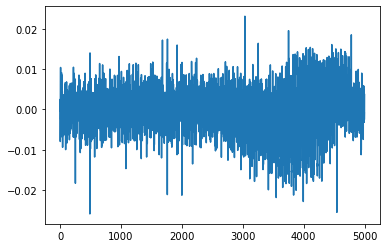

In [4]:
sig = dmel1[0][0]
plt.plot(torch.flip(sig, [1]).T)

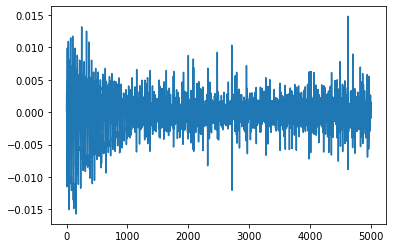

In [18]:
plt.plot(dmel1[0][0].T)

In [17]:
transforms_list = [Bandpass(), RandomFlip(p=0), RandomRoll()]

if normalize == "whole":
    dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Y", clean=True,transform=transforms.Compose(transforms_list))
    dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/L", clean=True, transform=transforms.Compose(transforms_list))
    transformed_dataset = ConcatDataset([dmel1, dsuz1])
    trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)

    mean, std = calc_mean_std_1D(loader=trainval_dataloader)
    transforms_list += [Normalize(mean=mean, std=std, axes=(0,2))]
elif normalize == "sample":
    transforms_list += [Normalize()]
else:
    pass

dmel1 = WingbeatsDataset(dsname="Melanogaster_RL/Z", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dmel2 = WingbeatsDataset(dsname="Melanogaster_RL/Y", custom_label=[0], clean=True, transform=transforms.Compose(transforms_list))
dsuz1 = WingbeatsDataset(dsname="Suzukii_RL/Y",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))
dsuz2 = WingbeatsDataset(dsname="Suzukii_RL/X",      custom_label=[1], clean=True, transform=transforms.Compose(transforms_list))

trainsets = [dmel1, dsuz1]
testsets = [dmel2, dsuz2]

transformed_dataset = ConcatDataset(trainsets)
trainval_dataloader = DataLoader(transformed_dataset, batch_size=batch_size, num_workers=num_workers)
train_size = int(0.8 * len(transformed_dataset))
valid_size = len(transformed_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(transformed_dataset, [train_size, valid_size])
test_dataset = ConcatDataset(testsets)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, num_workers=num_workers, shuffle=True)

Found 12150 in dataset: Melanogaster_RL/Z, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 12003 in dataset: Melanogaster_RL/Y, and 1 label(s): ['D. melanogaster']
Label(s) changed to [0]
Found 18166 in dataset: Suzukii_RL/Y, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]
Found 14703 in dataset: Suzukii_RL/X, and 1 label(s): ['D. suzukii']
Label(s) changed to [1]


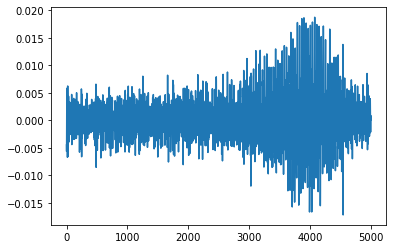

In [15]:
plt.plot(test_dataset[0][0].T)